# Getting Started

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, train_test_split

from aif360.sklearn.preprocessing import ReweighingMeta
from aif360.sklearn.inprocessing import AdversarialDebiasing
from aif360.sklearn.postprocessing import CalibratedEqualizedOdds, PostProcessingMeta
from aif360.sklearn.datasets import fetch_adult
from aif360.sklearn.metrics import disparate_impact_ratio, average_odds_error, generalized_fpr, generalized_fnr

## Loading data

Datasets are formatted as separate `X` (# samples x # features) and `y` (# samples x # labels) DataFrames. The index of each DataFrame contains protected attribute values per sample. Datasets may also load a `sample_weight` object to be used with certain algorithms/metrics. All of this makes it so that aif360 is compatible with scikit-learn objects.

For example, we can easily load the Adult dataset from UCI with the following line:

In [2]:
X, y, sample_weight = fetch_adult()
X.head()

,,,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
,race,sex,,,,,,,,,,,,,
0,Non-white,Male,25.0,Private,11th,7.0,Never-married,Machine-op-inspct,Own-child,Non-white,Male,0.0,0.0,40.0,United-States
1,White,Male,38.0,Private,HS-grad,9.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States
2,White,Male,28.0,Local-gov,Assoc-acdm,12.0,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,United-States
3,Non-white,Male,44.0,Private,Some-college,10.0,Married-civ-spouse,Machine-op-inspct,Husband,Non-white,Male,7688.0,0.0,40.0,United-States
5,White,Male,34.0,Private,10th,6.0,Never-married,Other-service,Not-in-family,White,Male,0.0,0.0,30.0,United-States


We can also easily load a version of the dataset which only contains numeric or binary columns and split it with scikit-learn:

In [3]:
X, y, sample_weight = fetch_adult(numeric_only=True)
(X_train, X_test,
 y_train, y_test) = train_test_split(X, y, train_size=0.7, shuffle=False)
X_train.head()

,,,age,education-num,race,sex,capital-gain,capital-loss,hours-per-week
,race,sex,,,,,,,
0,0,1,25.0,7.0,0,1,0.0,0.0,40.0
1,1,1,38.0,9.0,1,1,0.0,0.0,50.0
2,1,1,28.0,12.0,1,1,0.0,0.0,40.0
3,0,1,44.0,10.0,0,1,7688.0,0.0,40.0
4,1,0,18.0,10.0,1,0,0.0,0.0,30.0


the protected attribute information is replicated in the labels:

In [4]:
y_train.head()

   race  sex
0  0     1      0
1  1     1      0
2  1     1      1
3  0     1      1
4  1     0      0
Name: annual-income, dtype: int64

## Running metrics

With the data in this format, we can easily train a scikit-learn model and get predictions for the test data:

In [5]:
y_pred = LogisticRegression(solver='liblinear').fit(X_train, y_train).predict(X_test)
accuracy_score(y_test, y_pred)

0.823858595509452

Now, we can analyze our predictions and quickly calucate the disparate impact for females vs. males:

In [6]:
disparate_impact_ratio(y_test, y_pred, prot_attr='sex')

0.19826239080897468

And similarly, we can assess how close the predictions are to equality of odds.

`average_odds_error()` computes the (unweighted) average of the absolute values of the true positive rate (TPR) difference and false positive rate (FPR) difference, i.e.:

$\tfrac{1}{2}\left(|FPR_{D = \text{unprivileged}} - FPR_{D = \text{privileged}}|
           + |TPR_{D = \text{unprivileged}} - TPR_{D = \text{privileged}}|\right)$

In [7]:
average_odds_error(y_test, y_pred, prot_attr='sex')

0.12427040384779571

## Debiasing algorithms

`ReweighingMeta` is a workaround until changing sample weights can be handled properly in `Pipeline`/`GridSearchCV`

In [8]:
rew = ReweighingMeta(estimator=LogisticRegression(solver='liblinear'))

params = {'estimator__C': [1, 10], 'reweigher__prot_attr': ['sex']}

clf = GridSearchCV(rew, params, scoring='accuracy', cv=5)
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))
print(clf.best_params_)

0.8147819559134648
{'estimator__C': 10, 'reweigher__prot_attr': 'sex'}


In [9]:
disparate_impact_ratio(y_test, clf.predict(X_test), prot_attr='sex')

0.639237550613212

Rather than trying to weight accuracy and fairness, we can try a fair in-processing algorithm:

In [10]:
adv_deb = AdversarialDebiasing(prot_attr='sex')
adv_deb.fit(X_train, y_train)
adv_deb.score(X_test, y_test)

Instructions for updating:
Colocations handled automatically by placer.


0.8218794786050638

In [11]:
average_odds_error(y_test, adv_deb.predict(X_test), prot_attr='sex')

0.022611763594614448

Note that `AdversarialDebiasing` creates a TensorFlow session which we should close when we're finished to free up resources:

In [12]:
adv_deb.sess_.close()

Finally, let's try a post-processor, `CalibratedEqualizedOdds`.

Since the post-processor needs to be trained on data unseen by the original estimator, we will use the `PostProcessingMeta` class which splits the data and trains the estimator and post-processor with their own split.

In [13]:
cal_eq_odds = CalibratedEqualizedOdds('sex', cost_constraint='fnr')
log_reg = LogisticRegression(solver='liblinear')
postproc = PostProcessingMeta(estimator=log_reg, postprocessor=cal_eq_odds)

postproc.fit(X_train, y_train)
accuracy_score(y_test, postproc.predict(X_test))

0.7676926226711254

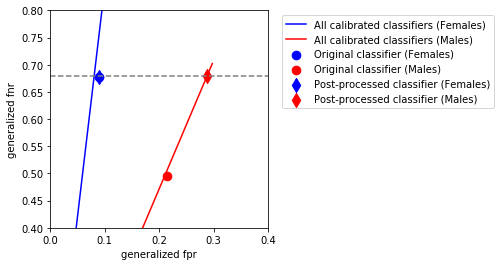

In [14]:
y_pred = postproc.predict_proba(X_test)[:, 1]
y_lr = postproc.estimator_.predict_proba(X_test)[:, 1]
br = postproc.postprocessor_.base_rates_
i = X_test.sex == 1

plt.plot([0, br[0]], [0, 1-br[0]], '-b', label='All calibrated classifiers (Females)')
plt.plot([0, br[1]], [0, 1-br[1]], '-r', label='All calibrated classifiers (Males)')

plt.scatter(generalized_fpr(y_test[~i], y_lr[~i]),
            generalized_fnr(y_test[~i], y_lr[~i]),
            300, c='b', marker='.', label='Original classifier (Females)')
plt.scatter(generalized_fpr(y_test[i], y_lr[i]),
            generalized_fnr(y_test[i], y_lr[i]),
            300, c='r', marker='.', label='Original classifier (Males)')
                                                                        
plt.scatter(generalized_fpr(y_test[~i], y_pred[~i]),
            generalized_fnr(y_test[~i], y_pred[~i]),
            100, c='b', marker='d', label='Post-processed classifier (Females)')
plt.scatter(generalized_fpr(y_test[i], y_pred[i]),
            generalized_fnr(y_test[i], y_pred[i]),
            100, c='r', marker='d', label='Post-processed classifier (Males)')

plt.plot([0, 1], [generalized_fnr(y_test, y_pred)]*2, '--', c='0.5')

plt.axis('square')
plt.xlim([0, 0.4])
plt.ylim([0.4, 0.8])
plt.xlabel('generalized fpr');
plt.ylabel('generalized fnr');
plt.legend(bbox_to_anchor=(1.04,1), loc='upper left');

We can see the generalized false negative rate is approximately equalized and the classifiers remain close to the calibration lines.